# Libraries

In [1]:
import os
import sys
import glob


import numpy as np
import pandas as pd
import copy as cp

import scipy
import scipy.signal

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord


import pickle
import shutil

import matplotlib.pyplot as plt
import matplotlib        as mpl
from matplotlib.patches import Ellipse
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from pathlib import Path
import more_itertools as mit

from scipy.spatial.distance import pdist, squareform

import seaborn as sns

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

script_dir

In [3]:
import libs.functions as fcn
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [4]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [5]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
hires_em_profile_path = hires_data / 'em_profiles'
abscatv2_data_path = hires_data / 'abscatv2'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'


abs_path = mwmc_data_path / 'absorption'
BIGHICAT_data_path = data_path / 'BIGHICAT'

# Absorption catalog Phase 2 version 2
print(abscatv2_data_path)

/Users/kiemhiep/ANU/ASKAP/data/LMC/hires/abscatv2


# Modules

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

In [7]:
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [8]:
# import gp as gp
from mpfit import mpfit

# Fcn

In [236]:
def boostrap_resampling_perturb_err(a, siga):
    n_bootstrap_samples = 1000
    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    medians = np.array([np.median(a + np.random.normal(0, 3.*siga)) for _ in range(n_bootstrap_samples)])

    median_uncertainty = np.std(medians)
    mean_uncertainty = np.std(medians)
    
    return mean_uncertainty, median_uncertainty

In [9]:
def boostrap_resampling_err(data):
    n_bootstrap_samples = 1000
    resampled_medians = np.empty(n_bootstrap_samples)
    resampled_means = np.empty(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        resampled_medians[i] = np.median(bootstrap_sample)
        resampled_means[i] = np.mean(bootstrap_sample)
    # Endfor

    median_uncertainty = np.std(resampled_medians)
    mean_uncertainty = np.std(resampled_means)
    
    return mean_uncertainty, median_uncertainty

In [10]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

# Read LMC catalogue

All MC sightlines

In [ ]:
spectra_filename = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
print(spectra_filename)
df = pd.read_csv(spectra_filename)
nsrcs, ncols = df.shape
print(f'Number of rows {nsrcs},\n Number of columns: {ncols}')
df.head(5)

In [19]:
field_ids = df['sbid'].unique()
print(f'Number of fields: {len(field_ids)}')
fields = ['sb'+str(x) for x in field_ids]
print('Fields: ', ', '.join([str(x) for x in field_ids]))
print()
print('Number of sources/sightlines in each field:')
df.groupby(['sbid'])['sbid'].count()

Number of fields: 10
Fields:  30665, 33047, 38814, 38791, 38845, 38215, 38373, 38466, 38758, 38509

Number of sources/sightlines in each field:


sbid
30665    346
33047    290
38215    268
38373    257
38466    261
38509    270
38758    200
38791    297
38814    242
38845    283
Name: sbid, dtype: int64

In [20]:
fields_series = df['sbid'].value_counts()
fields_series

30665    346
38791    297
33047    290
38845    283
38509    270
38215    268
38466    261
38373    257
38814    242
38758    200
Name: sbid, dtype: int64

In [21]:
# All sources
sources = df['comp_name'].unique()
print(f'Number of sources toward LMC: {len(sources)}')
print(f'Sources: {sources}')

Number of sources toward LMC: 2714
Sources: ['J005611-710706' 'J011049-731427' 'J011056-731406' ... 'J045340-751015'
 'J060302-715904' 'J051901-715032']


In [23]:
sbid = fields_series.index.to_list()
print(f'Fields: {sbid}')
sbid_counts = fields_series.values
print(f'sbid_counts: {sbid_counts}')

Fields: [30665, 38791, 33047, 38845, 38509, 38215, 38466, 38373, 38814, 38758]
sbid_counts: [346 297 290 283 270 268 261 257 242 200]


# Detections

In [34]:
field_det = {
    0 : [30665, 'gaskap_phase2_abs_catalogue_field0_30665_dr3.csv', ['J005337-723143', 'J011056-731406', 'J005611-710706', 'J005238-731244']], # SMC
    1 : [38373, 'gaskap_phase2_abs_catalogue_field1_38373_dr3.csv', ['J044512-654707', 'J044056-662423', 'J050504-641830']],
    2 : [38791, 'gaskap_phase2_abs_catalogue_field2_38791_dr3.csv', ['J054030-631513', 'J053249-634813']],
    3 : [38814, 'gaskap_phase2_abs_catalogue_field3_38814_dr3.csv', ['J035150-695934']],
    4 : [33047, 'gaskap_phase2_abs_catalogue_field4_33047_dr3.csv', ['J060111-703609', 'J053943-693847', 'J051832-693524']],
    5 : [38758, 'gaskap_phase2_abs_catalogue_field5_38758_dr3.csv', ['J040848-750719', 'J044025-762044', 'J040848-750719', 'J043534-745200', 'J035801-760516']],
    6 : [38845, 'gaskap_phase2_abs_catalogue_field6_38845_dr3.csv', ['J045438-751726', 'J052929-724528', 'J045859-754650', 'J054150-733215', 'J054150-733215', 'J061012-743157', 'J045438-751726']],
    7 : [38509, 'gaskap_phase2_abs_catalogue_field7_38509_dr3.csv', ['J031155-765150']],
    8 : [38466, 'gaskap_phase2_abs_catalogue_field8_38466_dr3.csv', ['J025246-710435', 'J025246-710431', 'J025245-710432', 'J025246-710434', 'J031610-682104']],
    9 : [38215, 'gaskap_phase2_abs_catalogue_field9_38215_dr3.csv', ['J012256-751507', 'J010249-795604']]
}

In [ ]:
ndet_total = 0
det_srcs = []
det_fields = []
for fieldn in field_det:
    field_id, fg_abs_filename, some_srcs = field_det.get(fieldn, None)
    fg_abs_filename = hires_data / fg_abs_filename
    print(field_id, fg_abs_filename, os.path.exists(fg_abs_filename))

    field = 'sb' + str(field_id)

    fg_abs_df = pd.read_csv(fg_abs_filename)
    print(f'Shape: {fg_abs_df.shape}')
    fg_abs_df.head()

    det_los = fg_abs_df[fg_abs_df['mwdet']]['comp_name'].values.tolist()
    n_det_los = len(det_los)
    print('det_los:', n_det_los)
    det_los[:4]

    det_srcs += det_los
    det_fields += [field_id]*n_det_los


    gfit_result_field_path = hires_results / field
    print(gfit_result_field_path)
    res_src_list = glob.glob(str(gfit_result_field_path / '*[0-9].pkl'))
    res_src_list = [x.replace(str(gfit_result_field_path) + '/', '').replace('.pkl', '') for x in res_src_list]
    print('res_src_list: ', len(res_src_list))
    res_src_list[:4]

    s = set(res_src_list)
    temp3 = [x for x in det_los if x not in s]
    print(temp3)

    s = set(det_los)
    temp3 = [x for x in res_src_list if x not in s]
    print(temp3)

    ndet_total += len(det_los)
# End - for
print(ndet_total)

# Read results: Read integrated properties

In [43]:
csv_filename   = hires_results / 'hires_result_table_dr3.csv' # DR3
gfit_result_df = pd.read_csv(csv_filename)
print(gfit_result_df.shape)
gfit_result_df.head(10)

(462, 42)


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,n_h,ew,sigew,ewfit,sigewfit,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm,Rfactor,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.898914,-0.788959,0.106568,0.005696,1.236612e+21,0.214960,0.227081,0.227081,0.006692,0.258148,0.017671,1.974700,0.100309,0.114780,0.009487,0.991403,0.050255,2.232849,0.101853,2.251126,0.048945,1,3.543176
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.547128,158.554968,0.603072,0.014683,4.874624e+21,0.086563,0.189310,0.189310,0.015265,0.673371,0.081768,2.090209,0.275080,0.244077,0.038535,1.033431,0.116433,2.763580,0.286976,2.673219,0.120832,2,3.573591
2,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.911926,0.889198,0.092196,0.011053,4.498524e+20,0.378402,0.376982,0.376982,0.015596,1.038635,0.153567,1.943385,0.808341,0.346858,0.114980,1.121981,0.333828,2.982020,0.822799,2.679519,0.113766,1,3.564467
3,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.505753,139.606872,0.681707,0.017343,5.650006e+20,0.297762,0.222502,0.222502,0.015980,0.359050,0.038501,2.377233,0.134253,0.130709,0.015873,1.013608,0.058216,2.736283,0.139665,2.701180,0.069134,1,3.485386
4,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.747348,-1.632904,0.291224,0.019113,2.560501e+20,0.785208,0.561212,0.561212,0.013125,0.868798,0.054916,2.789718,0.574751,0.236581,0.042168,0.996616,0.161232,3.658516,0.577369,3.670527,0.119231,1,3.473220
5,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,0.001285,0.014211,0.223862,3.712036,1.047509,91.0,5.545,4.165,163.320007,0.823646,-1.913442,0.194014,0.020262,2.490387e+20,0.878501,0.551155,0.551155,0.053517,0.969827,0.137638,1.760664,0.264103,0.355924,0.063481,1.032038,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342
6,J003824-742211,30665,J003824-742211-30665,9.602613,-74.369822,304.125905,-42.728214,0,A,234.746994,0.001272,0.009595,0.539868,13.739143,1.036628,79.0,5.110,4.495,4.600000,0.496760,149.310459,0.699648,0.024721,2.311093e+21,0.328374,0.314306,0.314306,0.016083,0.586766,0.063750,2.279359,0.200747,0.204896,0.026656,1.006075,0.084653,2.866125,0.210626,2.849640,0.119482,1,3.503636
7,J004330-704147,30665,J004330-704147-30665,10.877976,-70.696568,303.881910,-46.417060,0,B,208.011002,0.000753,0.011347,0.080232,1.183264,1.036749,114.0,6.155,5.750,129.220001,0.956517,-2.563755,0.044457,0.013561,2.227711e+20,0.086494,0.096051,0.096051,0.017884,0.115427,0.039083,2.144274,0.482831,0.050945,0.021139,1.064826,0.224735,2.259701,0.484410,2.133405,0.102399,1,3.546217
8,J012930-733309,30665,J012930-733309-30665,22.375798,-73.552722,299.244025,-43.301902,0,A,168.481003,0.000750,0.031289,0.509612,4.942768,1.085753,108.0,5.360,4.965,178.339996,0.576142,0.063744,0.551402,0.064168,1.993999e+21,0.896668,0.639419,0.639419,0.025520,0.939507,0.030780,2.633537,0.134636,0.265930,0.013705,1.107691,0.051617,3.573044,0.138110,3.232634,0.079281,1,3.448888
9,J005219-722705,30665,J005219-722705-30665,13.079073,-72.451417,302.838808,-44.676675,0,A,72.601997,0.000785,0.019172,0.291124,3.276537,1.068075,94.0,5.160,4.590,49.650002,0.776951,154.999004,0.252379,0.039084,4.655635e+21,

In [226]:
# Mean FCNM
np.mean(gfit_result_df.fcnm.values)

0.2938031453275031

In [244]:
np.sqrt(np.sum(gfit_result_df.sigfcnm.values**2))/np.sqrt(462)

0.04140930681662396

In [246]:
boostrap_resampling_perturb_err(gfit_result_df.fcnm.values, gfit_result_df.sigfcnm.values)

(0.0071103931623318455, 0.0071103931623318455)

In [253]:
def bootstrap(data, num_samples=10000):
    """Perform bootstrapping on the given data."""
    n = len(data)
    means = np.empty(num_samples)
    medians = np.empty(num_samples)
    
    for i in range(num_samples):
        sample = np.random.choice(data, size=n, replace=True)
        means[i] = np.mean(sample)
        medians[i] = np.median(sample)
    
    return means, medians


# Calculate mean and median of original data
mean = np.mean(a)
median = np.median(a)

# Perform bootstrapping
num_bootstrap_samples = 10000
means, medians = bootstrap(a, num_samples=num_bootstrap_samples)

# Calculate uncertainties
mean_uncertainty = np.std(means)
median_uncertainty = np.std(medians)

print(f"Mean: {mean:.2f} ± {mean_uncertainty:.2f}")
print(f"Median: {median:.2f} ± {median_uncertainty:.2f}")


Mean: 0.29 ± 0.01
Median: 0.28 ± 0.01


In [256]:
def bootstrap(data, errors, num_samples=10000):
    """Perform bootstrapping on the given data with associated errors."""
    n = len(data)
    means = np.empty(num_samples)
    medians = np.empty(num_samples)
    
    for i in range(num_samples):
        # Create a sample by resampling with replacement and adding error
        indices = np.random.choice(n, size=n, replace=True)
        sample = data[indices] + np.random.normal(0, 10.*errors[indices])
        means[i] = np.mean(sample)
        medians[i] = np.median(sample)
    
    return means, medians

# Example data
# Calculate mean and median of original data
mean = np.mean(a)
median = np.median(a)

# Perform bootstrapping
num_bootstrap_samples = 10000
means, medians = bootstrap(a, b, num_samples=num_bootstrap_samples)

# Calculate uncertainties
mean_uncertainty = np.std(means)
median_uncertainty = np.std(medians)

print(f"Mean: {mean:.2f} ± {mean_uncertainty:.2f}")
print(f"Median: {median:.2f} ± {median_uncertainty:.2f}")


Mean: 0.29 ± 0.02
Median: 0.28 ± 0.02


In [46]:
detsrc_glon = gfit_result_df.glon.values
detsrc_glat = gfit_result_df.glat.values

detsrc_ra = gfit_result_df.ra.values
detsrc_dec = gfit_result_df.dec.values

detsrc_list = gfit_result_df.comp_name.values

In [47]:
def ra_dec_to_cartesian(ra, dec):
    # Convert degrees to radians
    ra_rad = np.deg2rad(ra)
    dec_rad = np.deg2rad(dec)
    
    # Cartesian coordinates
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    
    return x, y, z


def angular_distances(x, y, z):
    # Stack coordinates into a single array
    coords = np.vstack((x, y, z)).T
    dist_matrix = squareform(pdist(coords, metric='cosine'))
    angular_distance_rad = np.arccos(1. - dist_matrix)
    angular_distance_arcsec = np.rad2deg(angular_distance_rad) * 3600
    return angular_distance_arcsec


def filter_distances(distances, min_distance, max_distance):
    indices = np.where((distances > min_distance) & (distances < max_distance))
    unique_pairs = [(i, j) for i, j in zip(indices[0], indices[1]) if i < j]
    return unique_pairs

In [48]:
# Convert to Cartesian coordinates
x, y, z = ra_dec_to_cartesian(detsrc_ra, detsrc_dec)

# Calculate angular distances in arcseconds
distances = angular_distances(x, y, z)

# Filter distances
min_distance = 50.  # arcseconds
max_distance = 60.  # arcseconds

close_targets = filter_distances(distances, min_distance, max_distance)
print(len(close_targets))
print(close_targets)

# Display results
for pair in close_targets:
    print(f"Target {pair[0]} and Target {pair[1]} are close with an angular distance between {min_distance} arcseconds and {max_distance} arcseconds.")


4
[(309, 361), (312, 313), (417, 418), (450, 457)]
Target 309 and Target 361 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.
Target 312 and Target 313 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.
Target 417 and Target 418 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.
Target 450 and Target 457 are close with an angular distance between 50.0 arcseconds and 60.0 arcseconds.


# Read CNM components

In [50]:
csv_filename = hires_results / 'hires_result_CNM_components_dr3.csv' # DR3
gfit_cpn_result_df = pd.read_csv(csv_filename)
print(gfit_cpn_result_df.shape)
gfit_cpn_result_df.head(10)

(691, 39)


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
5,J004741-753010,30665,J004741-753010-30665,11.920932,-75.502942,303.246204,-41.623018,0,A,305.752991,0.001378,0.012283,0.283696,8.138546,1.031044,90.0,5.265,4.940,171.570007,0.250228,0.006430,0.012771,-0.990880,0.035323,3.092582,0.079347,56.806365,4.810935,12.278083,0.769829,0.868798,0.054916,0.237473,0.040371,3.658516,0.577369,3.473220,0.852766,0.078579
6,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,0.001285,0.014211,0.223862,3.712036,1.047509,91.0,5.545,4.165,163.320007,0.090734,0.014163,0.014662,-2.045776,0.094471,1.604501,0.283611,39.228026,16.332487,9.751173,0.798455,0.104369,0.047078,0.038223,0.017739,2.730491,0.297817,3.555342,0.110785,0.053010
7,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,0.001285,0.014211,0.223862,3.712036,1.047509,91.0,5.545,4.165,163.320007,0.099096,0.012114,0.014662,-1.024331,0.180142,4.963483,0.338277,92.364982,12.186470,10.372669,0.798455,0.865458,0.129336,0.316961,0.058642,2.730491,0.297817,3.555342,0.881302,0.169516
8,J003824-742211,30665,J003824-742211-30665,9.602613,-74.369822,304.125905,-42.728214,0,A,234.746994,0.001272,0.009595,0.539868,13.739143,1.036628,79.0,5.110,4.495,4.600000,0.089794,0.003819,0.009851,-1.153054,0.078004,3.947628,0.178987,83.949909,10.997951,7.053374,0.896473,0.586766,0.063750,0.204725,0.026853,2.866125,0.210626,3.503636,0.577268,0.083707
9,J004330-704147,30665,J004330-704147-30665,10.877976,-70.696568,303.881910,-46.417060,0,B,208.011002,0.000753,0.011347,0.080232,1.183264,1.036749,114.0,6.155,5.750,129.220001,0.043047,0.005625,0.011567,-2.794035,0.138133,2.203807,0.321730,65.769937,22.157281,2.356820,1.076401,0.115427,0.039083,0.051081,0.020471,2.259701,0.484410,3.546217,0.121037,0.047170


In [ ]:
src_list = gfit_cpn_result_df.uniq_name.values
for k,srci in enumerate(src_list):
    if k == 2:
        print(srci)
        src_df = gfit_cpn_result_df[gfit_cpn_result_df.uniq_name == srci]
        src_ts = src_df.tscnm.values
        src_nhicnm = src_df.nhicnm_cpn.values
        print(src_ts)
        print(src_nhicnm)
        avg_ts = np.average(src_ts, weights=src_nhicnm)
        print(avg_ts)

# CNM with Ts < 250

In [53]:
gfit_cnm_cpn_df = gfit_cpn_result_df[gfit_cpn_result_df.tscnm < 250.5]
gfit_cnm_cpn_srcs = gfit_cnm_cpn_df.comp_name.unique()
gfit_cnm_cpn_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,1.381515,0.385456,0.233672,0.755664,0.165140,2.210733,0.338032,27.020567,3.721899,17.238146,0.453207,1.416348,0.171045,0.225989,0.028857,6.267342,0.260013,3.515802,1.600893,0.555026
687,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.421614,0.017670,0.023883,7.434009,0.035521,2.055398,0.079110,35.538772,4.928284,10.852738,0.790409,0.572984,0.057847,0.134791,0.073315,4.250919,2.271969,3.430639,0.597434,0.089552
688,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.265958,0.017947,0.037130,7.076890,0.102529,3.626937,0.234743,59.134648,3.256338,14.051706,0.503125,1.140123,0.059094,0.253422,0.017857,4.498908,0.214756,3.409348,1.106552,0.120073
689,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.176693,0.020038,0.037130,-0.000135,0.126679,2.513307,0.290737,77.354570,5.335641,12.817144,0.503125,0.687252,0.052560,0.152760,0.013772,4.498908,0.214756,3.409348,0.666387,0.117329


# Optical depth

In [57]:
# Optical depth
fg_taucnm = gfit_cpn_result_df.taucnm.values
sig_tau_noise = gfit_cpn_result_df.sigtaunoise.values
fg_sigtaucnm = gfit_cpn_result_df.sigtaucnm.values
glon = gfit_cpn_result_df.glon.values
glat = gfit_cpn_result_df.glat.values

total_ncnm = len(fg_taucnm)
print(f'Total CNM components: {total_ncnm}')

Total CNM components: 691


In [58]:
stats_series = pd.DataFrame(fg_taucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,0.474371
std,0.441789
min,0.014090
25%,0.159337
50%,0.353273
75%,0.646146
max,2.915342


In [59]:
tau_count = int(series_values[0])
tau_mean = round(series_values[1], 2)
tau_std = round(series_values[2], 2)
tau_minval = round(series_values[3], 4)
tau_maxval = round(series_values[-1], 4)
tau_median = round(series_values[5], 2)
tau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
tau_stats_values = [tau_count, tau_mean, tau_median, tau_std, tau_minval, tau_maxval]

In [60]:
sig_tau_noise = np.asarray(sig_tau_noise)
low_sigtau_id = np.where(sig_tau_noise < 0.05)[0]
hgt_sigtau_id = np.where(sig_tau_noise >= 0.05)[0]

In [62]:
fg_sigtaucnm_lownoise = fg_sigtaucnm[low_sigtau_id]

In [64]:
# Optical depth
taumin = min(fg_taucnm)
taumax = max(fg_taucnm)

gl_tau  = np.array(glon)
gb_tau  = np.array(glat)

ind_tau = np.argsort(fg_taucnm)
ind_tau = ind_tau[::-1]
taucnm_sorted = fg_taucnm[ind_tau]
gl_tau = gl_tau[ind_tau]
gb_tau = gb_tau[ind_tau]

In [66]:
stats_series = pd.DataFrame(fg_sigtaucnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,0.064019
std,0.116306
min,0.001003
25%,0.013715
50%,0.028623
75%,0.070638
max,1.745435


In [67]:
sigtau_count = int(series_values[0])
sigtau_mean = round(series_values[1], 1)
sigtau_std = round(series_values[2], 1)
sigtau_minval = round(series_values[3], 1)
sigtau_maxval = round(series_values[-1], 1)
sigtau_median = round(series_values[5], 1)
sigtau_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
sigtau_stats_values = [sigtau_count, sigtau_mean, sigtau_median, sigtau_std, sigtau_minval, sigtau_maxval]
sigtau_units = ['', '', '', '', '', '']

# HI spin temperature

In [70]:
tscnm = gfit_cpn_result_df.tscnm.values
sigtscnm = gfit_cpn_result_df.sigtscnm.values
nhicnm_cpn = gfit_cpn_result_df.nhicnm_cpn.values
signhicnm_cpn = gfit_cpn_result_df.signhicnm_cpn.values

In [71]:
stats_series = pd.DataFrame(tscnm).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,60.108511
std,40.618373
min,11.278219
25%,34.908276
50%,49.985345
75%,71.759273
max,307.047625


In [72]:
ts_count = int(series_values[0])
ts_mean = round(series_values[1], 1)
ts_std = round(series_values[2], 1)
ts_minval = round(series_values[3], 1)
ts_maxval = round(series_values[-1], 1)
ts_median = round(series_values[5], 1)
ts_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
ts_stats_values = [ts_count, ts_mean, ts_median, ts_std, ts_minval, ts_maxval]
ts_units = ['', 'K', 'K', 'K', 'K', 'K']

In [74]:
tsmin = min(tscnm)
tsmax = max(tscnm)

gl_ts  = np.array(glon)
gb_ts  = np.array(glat)

ind_ts = np.argsort(tscnm)
ind_ts = ind_ts[::-1]
tscnm_sorted = tscnm[ind_ts]
gl_ts  = gl_ts[ind_ts]
gb_ts  = gb_ts[ind_ts]

## Purely from radiative transfer

In [85]:
# Const
mh = 1.6737236e-24 # gram

# Const
m_h = 1.6737236e-27 # kg

dz  = 40./1024. #pc Saury14
print('Saury14 dz: ', dz)

dz  = 200./512. #pc seta22
print('Seta22 dz: ', dz)




# Velocity range and channel spacing
vmin = -50. #km.s-1
vmax = 50. #km.s-1
dv = 0.3125 # 0.15625 # 0.8 #km.s-1
v = np.arange(vmin, vmax, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
at_v = np.arange(vmin, vmax+dv, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
nchan = len(v)
print('nchan: ', nchan)


constC = 1.8224e18
dz = 0.03 # pc
print('Current dz (pc): ', dz)

# nhi = INT{n * ds}, path length ds in cm
parsec_to_cm = 3.086e18  # 1 parsec in cm
dz_cm = parsec_to_cm*dz

Saury14 dz:  0.0390625
Seta22 dz:  0.390625
nchan:  320
Current dz (pc):  0.03


In [87]:
# Parameters
v0 = 0.             # Mean velocity in km/s
m = 1.6735575e-27   # Mass of a hydrogen atom in kg
k_B = 1.380649e-23  # Boltzmann constant in J/K

# $N_\text{HI,CNM}$

In [92]:
gfit_cpn_result_df.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'taucnm', 'sigtaucnm',
       'sigtaunoise', 'cencnm', 'sigcencnm', 'widcnm', 'sigwidcnm', 'tscnm',
       'sigtscnm', 'tbcnm', 'sigtbcnm', 'nhicnm_cpn', 'signhicnm_cpn',
       'fcnm_cpn', 'sigfcnm_cpn', 'nhi_tot', 'signhi_tot', 'tsky',
       'nhicnm_avg', 'signhicnm_avg'],
      dtype='object')

In [93]:
gfit_cpn_result_df[gfit_cpn_result_df.nhicnm_cpn < 0.1]

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
13,J011432-732142,30665,J011432-732142-30665,18.636736,-73.361881,300.648529,-43.663768,0,A,150.199997,0.000549,0.019137,1.031000,11.379246,1.083285,92.0,5.265000,4.925000,179.460007,0.082687,0.010999,0.019490,-0.132503,0.113816,1.800077,0.263023,43.395994,14.399703,2.449321,1.090926,0.090279,0.046284,0.037510,0.020277,2.406786,0.412504,3.558383,0.125301,0.048391
14,J003424-721143,30665,J003424-721143-30665,8.602290,-72.195374,304.767373,-44.872140,0,B,142.589005,0.000573,0.018301,0.217136,2.483276,1.062337,129.0,5.340000,4.890000,18.240000,0.055127,0.011451,0.018810,3.736607,0.168737,1.483285,0.393791,53.287516,28.266064,3.499855,0.873885,0.086698,0.040871,0.029799,0.014439,2.909400,0.325797,3.546217,0.084527,0.053124
24,J002907-735349,30665,J002907-735349-30665,7.280587,-73.896955,305.049664,-43.139415,0,A,74.181000,0.000386,0.027345,0.864979,7.532314,1.101377,140.0,5.205000,4.605000,10.890000,0.105347,0.018839,0.027881,5.905132,0.096425,1.138581,0.224320,24.761122,12.061166,1.730318,0.798380,0.055401,0.026884,0.017176,0.010183,3.225556,1.098784,3.567508,0.057615,0.031978
70,J054105-630817,38791,J054105-630817-38791,85.272849,-63.138061,272.448378,-31.889720,0,B,55.050999,0.000460,0.041418,0.407289,1.563777,1.158863,101.0,5.145000,4.145000,63.049999,0.269779,0.036356,0.043531,3.724385,0.077899,1.268506,0.175621,17.201301,11.981097,2.542415,1.075321,0.098501,0.067394,0.023548,0.016403,4.182931,0.546369,3.290727,0.114193,0.082541
107,J042835-674912,38814,J042835-674912-38814,67.148920,-67.820124,279.974844,-38.195996,0,B,455.487000,0.002133,0.009399,0.073947,1.368245,1.031224,91.0,5.120000,4.090000,56.279999,0.042333,0.004703,0.009672,4.714930,0.113923,2.125225,0.265965,53.829082,19.768775,2.047890,0.877488,0.099168,0.033134,0.037425,0.034039,2.649742,2.241440,3.305935,0.093946,0.037915
209,J053836-690555,33047,J053836-690555-33047,84.652473,-69.098884,279.463921,-31.680691,0,A,89.018997,0.000019,0.013020,0.948712,18.346593,1.049038,69.0,77.114998,31.985001,14.790000,0.063223,0.006409,0.013695,-2.048477,0.120086,2.363768,0.284456,36.584575,32.387375,2.040640,1.500000,0.094262,0.087837,0.021148,0.019954,4.457179,0.659604,5.584053,0.106060,0.095364
219,J052502-693902,33047,J052502-693902-33047,81.259902,-69.650728,280.314613,-32.782629,0,A,76.478996,0.000032,0.010379,0.747510,20.687083,1.034468,81.0,26.174999,18.245001,55.240002,0.094440,0.005763,0.010817,8.739262,0.054552,1.878893,0.126594,26.939479,22.083814,2.431641,1.061256,0.094624,0.061701,0.019854,0.016389,4.766017,2.412549,4.032865,0.092730,0.076482


In [94]:
gfit_cpn_result_df[gfit_cpn_result_df.taucnm > 2.75]

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
321,J035845-720848,38758,J035845-720848-38758,59.690826,-72.146799,286.361858,-38.367057,1,B,38.104,0.000207,0.109549,1.267008,2.863866,1.327912,66.0,5.02,4.25,48.220001,2.893319,0.485309,0.143457,7.887947,0.062003,1.812894,0.120316,17.714438,2.151906,14.037709,0.375235,1.519455,0.194522,0.221973,0.046026,6.845219,1.116528,3.269437,1.802486,0.391999
579,J041040-771121,38509,J041040-771121-38509,62.668234,-77.189322,291.015043,-34.888643,1,C,18.486,0.000077,0.179689,1.715159,1.352773,1.728995,127.0,5.01,4.49,40.080002,2.915342,1.745435,0.335069,2.894137,0.111747,1.422541,0.281195,29.896799,2.972071,38.331993,0.356350,3.337619,0.503377,0.437849,0.072489,7.622769,0.520511,3.372849,2.405221,1.535213


In [220]:
gfit_cpn_result_df

,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,taucnm,sigtaucnm,sigtaunoise,cencnm,sigcencnm,widcnm,sigwidcnm,tscnm,sigtscnm,tbcnm,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,4.800,4.215,33.869999,0.094983,0.002162,0.004565,-1.140378,0.027208,2.547627,0.063012,52.597993,4.691695,4.792557,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.040406,0.002042,0.005290,0.974041,0.095486,3.642994,0.238888,184.275606,22.602078,7.266817,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,5.790,5.350,54.860001,0.014090,0.002040,0.005290,-4.196397,0.240039,3.019618,0.586649,175.371389,68.342573,2.346904,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,5.230,4.905,175.600006,0.076748,0.002789,0.008792,0.317075,0.097088,5.792015,0.222705,119.640327,21.679161,8.750900,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,5.230,4.895,175.509995,0.053298,0.002950,0.008432,0.364399,0.115375,4.436012,0.266351,77.722109,9.762152,3.968599,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,J014454-801334,38215,J014454-801334-38215,26.225640,-80.226328,300.129741,-36.609263,1,B,20.705000,0.000200,0.182675,1.403734,1.770192,1.506728,75.0,4.165,4.025,70.760002,1.381515,0.385456,0.233672,0.755664,0.165140,2.210733,0.338032,27.020567,3.721899,17.238146,0.453207,1.416348,0.171045,0.225989,0.028857,6.267342,0.260013,3.515802,1.600893,0.555026
687,J012808-751251,38215,J012808-751251-38215,22.036673,-75.214201,299.807394,-41.690592,1,B,148.449997,0.001101,0.019195,0.426576,2.945407,1.108120,166.0,4.250,3.990,87.809998,0.421614,0.017670,0.023883,7.434009,0.035521,2.055398,0.079110,35.538772,4.928284,10.852738,0.790409,0.572984,0.057847,0.134791,0.073315,4.250919,2.271969,3.430639,0.597434,0.089552
688,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.265958,0.017947,0.037130,7.076890,0.102529,3.626937,0.234743,59.134648,3.256338,14.051706,0.503125,1.140123,0.059094,0.253422,0.017857,4.498908,0.214756,3.409348,1.106552,0.120073
689,J010238-762315,38215,J010238-762315-38215,15.659985,-76.387702,302.062577,-40.721635,1,A,62.705002,0.000654,0.035138,0.384686,3.201754,1.091554,78.0,4.330,4.240,110.279999,0.176693,0.020038,0.037130,-0.000135,0.126679,2.513307,0.290737,77.354570,5.335641,12.817144,0.503125,0.687252,0.052560,0.152760,0.013772,4.498908,0.214756,3.409348,0.666387,0.117329


In [95]:
nhicnm_cpn = gfit_cpn_result_df.nhicnm_avg.values
signhicnm_cpn = gfit_cpn_result_df.signhicnm_avg.values
src_list_cpn = gfit_cpn_result_df.comp_name.values
widcnm = gfit_cpn_result_df.widcnm.values

In [96]:
stats_series = pd.DataFrame(nhicnm_cpn).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,691.000000
mean,1.208421
std,0.971190
min,0.057615
25%,0.462790
50%,0.921952
75%,1.769314
max,4.735151


In [97]:
nhicnm_cpn_count = int(series_values[0])
nhicnm_cpn_mean = round(series_values[1], 1)
nhicnm_cpn_std = round(series_values[2], 1)
nhicnm_cpn_minval = round(series_values[3], 1)
nhicnm_cpn_maxval = round(series_values[-1], 1)
nhicnm_cpn_median = round(series_values[5], 1)
nhicnm_cpn_labels = ['Total CNM components', 'Mean', 'Median', 'std', 'Min', 'Max']
nhicnm_cpn_stats_values = [nhicnm_cpn_count, nhicnm_cpn_mean, nhicnm_cpn_median, nhicnm_cpn_std, nhicnm_cpn_minval, nhicnm_cpn_maxval]
nhicnm_cpn_units = ['', r'$\times 10^{20}$', r'$\times 10^{20}$', r'$\times 10^{20}$', r'$\times 10^{20}$', r'$\times 10^{20}$']

In [106]:
const1 = 2.*np.sqrt(2.*np.log(2.))
print(const1)
constC1 = np.sqrt(2.*np.pi)* (0.018224)/const1 
constC1

2.3548200450309493


0.019398846962114667

# HT03: Ts and tau

In [115]:
mil_datafile = BIGHICAT_data_path / 'nhi_lb_79src_HT03.csv'
mil_df = pd.read_csv(mil_datafile)
mil_df

,ID,source,l,b,nhi,nhi_er,thin,thin_er,cnm,cnm_er,wnm,wnm_er
0,0,3C33,129.4481,-49.3244,2.7800,0.0400,2.8239,0.0680,1.64,0.0232,1.1400,0.0357
1,1,3C18,118.6218,-52.7266,5.9900,0.9500,5.1766,0.0315,5.24,0.9450,0.7500,0.0561
2,2,3C141.0,174.5324,-1.3112,52.6900,1.4800,40.9027,0.5363,23.64,1.2509,29.0500,0.7996
3,3,3C142.1,197.6157,-14.5115,21.9600,2.3000,17.2260,0.7261,8.10,2.2459,13.8600,0.5171
4,4,3C138,187.4052,-11.3437,19.8400,0.9900,17.4826,0.2399,10.69,0.9004,9.1500,0.4088
...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,P0320+05,176.9818,-40.8433,11.2000,0.4800,9.9975,0.7438,5.05,0.3183,6.1500,0.3610
75,75,3C274.1,269.8744,83.1637,2.3600,0.0400,2.2860,0.1201,0.30,0.0193,2.0600,0.0293
76,76,3C207,212.9680,30.1390,5.2500,0.1500,4.9461,0.0969,0.91,0.1267,4.3400,0.0870
77,77,T0629+10,201.5315,0.5079,59.2500,2.8600,45.1748,0.1705,37.02,2.5766,22.2300,1.2404


In [116]:
mil_datafile = BIGHICAT_data_path / 'cpn_params_HT03.csv'
mil_cpn_df = pd.read_csv(mil_datafile)
mil_cpn_df = mil_cpn_df.merge(mil_df[['source', 'l', 'b']], on='source', how='left')
mil_cpn_df['isCNM'] = (mil_cpn_df.Tser > -0.1)
mil_cpn_df = mil_cpn_df[np.abs(mil_cpn_df.b.values) > 9.5]
mil_cpn_df = mil_cpn_df[mil_cpn_df.isCNM]
mil_cpn_df = mil_cpn_df[mil_cpn_df.tau < 4.]
mil_cpn_df = mil_cpn_df[mil_cpn_df.Tspin > 0.]
mil_cpn_df

,Tpeak,Ter,tau,tauer,Vlsr,Ver,delV,dVer,Tspin,Tser,Tkmax,NHI,NHIer,CNM,Frac,Fer,source,l,b,isCNM
1,16.71,-12.0,0.669,0.011,-8.9,0.0,2.43,0.03,34.25,7.89,129.0,1.09,0.2498,1,-18.0,-18.0,3C18,118.6218,-52.7266,True
2,19.80,-12.0,0.077,0.019,-6.7,0.2,8.62,0.70,267.80,5.28,1625.0,3.46,0.8983,0,-18.0,-18.0,3C18,118.6218,-52.7266,True
3,8.09,-12.0,0.181,0.018,-5.7,0.1,3.98,0.25,48.75,9.41,346.0,0.69,0.1540,2,-18.0,-18.0,3C18,118.6218,-52.7266,True
5,10.41,-12.0,0.034,0.001,-4.6,0.1,9.44,0.30,309.63,4.79,1949.0,1.95,0.0886,0,-18.0,-18.0,3C33-1,129.4392,-49.3432,True
7,10.20,-12.0,0.059,0.002,-4.2,0.2,9.31,0.42,177.85,4.54,1892.0,1.90,0.1174,0,-18.0,-18.0,3C33-2,129.4620,-49.2774,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,19.33,-12.0,1.132,0.016,3.2,0.0,3.42,0.04,28.52,19.69,255.0,2.15,1.4793,2,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
339,24.22,-12.0,1.318,0.040,9.2,0.0,3.70,0.05,33.07,18.46,298.0,3.14,1.7494,1,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
340,21.22,-12.0,2.346,0.128,10.6,0.0,1.50,0.05,23.47,9.38,49.0,1.61,0.6485,0,-18.0,-18.0,P0428+20,176.8082,-18.5568,True
352,1.47,-12.0,0.010,0.001,-4.6,0.1,7.94,0.30,149.01,6.39,1379.0,0.23,0.0264,1,-18.0,-18.0,P1055+20,222.5101,63.1302,True


In [117]:
# Millennium03
mil_cpn_srcs = mil_cpn_df.source.values
mil_cpn_tau = mil_cpn_df.tau.values
mil_cpn_sigtau = mil_cpn_df.tauer.values

mil_cpn_wid = mil_cpn_df.delV.values
mil_cpn_sigwid = mil_cpn_df.dVer.values

mil_cpn_nhicnm = mil_cpn_df.NHI.values
mil_cpn_signhicnm = mil_cpn_df.NHIer.values

mil_cpn_ts = mil_cpn_df.Tspin.values
mil_cpn_sigts = mil_cpn_df.Tser.values
mil_ncnm = mil_cpn_ts.shape[0]
print('Millennium03', mil_ncnm)

Millennium03 150


In [118]:
mil_uniq_srcs = np.unique(mil_cpn_srcs)
mil_uniq_srcs

array(['3C105', '3C109', '3C120', '3C123', '3C132', '3C133', '3C138',
       '3C142.1', '3C172.0', '3C18', '3C192', '3C207', '3C225a', '3C225b',
       '3C228.0', '3C237', '3C245', '3C272.1', '3C273', '3C274.1',
       '3C310', '3C315', '3C318', '3C33', '3C33-1', '3C33-2', '3C333',
       '3C348', '3C353', '3C433', '3C454.0', '3C454.3', '3C64', '3C75',
       '3C75-1', '3C75-2', '3C78', '3C79', '3C93.1', '3C98', '3C98-1',
       '3C98-2', '4C07.32', '4C13.65', '4C20.33', '4C32.44', 'CTA21',
       'P0320+05', 'P0347+05', 'P0428+20', 'P1055+20'], dtype=object)

In [120]:
ms_datafile = BIGHICAT_data_path / 'nhi_lb_79src_HT03.csv'
mil_df = pd.read_csv(ms_datafile)
mil_df = mil_df[mil_df.source.isin(mil_uniq_srcs)]
mil_srcs = mil_df.source.unique()
mil_nlos = len(mil_srcs)
print(mil_nlos)

mil_nhi_los = mil_df.groupby('source').sum().nhi.values
print(mil_nhi_los.shape)
print(mil_nhi_los)

51
(51,)
[14.68 20.82 15.94 27.38 23.81 28.5  19.84 21.96  7.71  5.99  3.97  5.25
  3.4   3.28  2.61  2.2   2.03  2.39  1.93  2.36  3.71  4.77  4.75  2.78
  2.81  2.92  5.09  5.69 10.85  7.89  5.38  6.53  6.33  7.89  7.97  8.23
 10.06  9.37 12.32 11.02 10.37 10.25  2.11  9.16  2.69  1.05  9.56 11.2
 13.45 23.89  1.57]


# S14: Ts and Tau

In [122]:
perseus_datafile = BIGHICAT_data_path / 'SF14_params.csv'
per_cpn_df = pd.read_csv(perseus_datafile)
per_cpn_df['CNM'] = (per_cpn_df.e_Ts > -0.1)
per_cpn_df

,ID,TB,e_TB,VLSR,e_VLSR,DelV,e_DelV,tau,e_tau,Ts,e_Ts,Tkmax,NHI,ForO,CNM
0,3C067,1.88,0.06,-25.8,0.1,4.71,0.18,0.006,-99.000,331.00,-999.00,835,0.17,1.0,False
1,3C067,1.95,0.00,-11.6,0.4,41.30,0.64,0.004,-99.000,438.00,-999.00,2077,1.27,0.0,False
2,3C067,5.34,-9.00,-5.8,0.1,4.81,0.18,0.096,0.002,69.10,8.88,325,0.62,2.0,True
3,3C067,21.02,0.35,-2.3,0.2,9.75,0.17,0.017,-99.000,1254.00,-999.00,861,3.99,0.5,False
4,3C067,23.05,-9.00,-0.3,0.0,2.14,0.04,0.412,0.008,42.88,8.28,607,0.74,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,NV0232+34,2.69,0.03,-6.5,0.1,39.32,0.37,0.011,-99.000,245.00,-999.00,33787,1.68,0.0,False
178,NV0232+34,20.16,-9.00,-1.9,0.1,2.04,0.16,0.130,0.010,43.04,8.28,607,0.22,0.0,True
179,NV0232+34,22.52,-9.00,-0.1,0.2,8.49,0.71,0.058,0.014,321.07,8.88,325,3.10,2.0,True
180,NV0232+34,22.90,-9.00,0.4,0.0,1.82,0.09,0.200,0.012,37.38,14.82,489,0.27,3.0,True


In [123]:
per_cpn_df = per_cpn_df[per_cpn_df.CNM]
per_cpn_df

,ID,TB,e_TB,VLSR,e_VLSR,DelV,e_DelV,tau,e_tau,Ts,e_Ts,Tkmax,NHI,ForO,CNM
2,3C067,5.34,-9.0,-5.8,0.1,4.81,0.18,0.096,0.002,69.10,8.88,325,0.62,2.0,True
4,3C067,23.05,-9.0,-0.3,0.0,2.14,0.04,0.412,0.008,42.88,8.28,607,0.74,0.0,True
5,3C067,17.71,-9.0,1.2,0.1,5.99,0.13,0.186,0.005,89.34,14.82,489,1.94,1.0,True
8,3C068.2,5.09,-9.0,-6.2,0.0,2.58,0.07,0.270,0.000,19.75,8.88,144,0.27,0.0,True
9,3C068.2,-0.09,-9.0,-3.0,0.1,2.63,0.24,0.088,0.004,4.11,8.28,151,0.02,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NV0157+28,13.69,-9.0,-0.5,0.0,1.96,0.12,0.040,0.002,25.80,8.28,607,0.04,0.0,True
178,NV0232+34,20.16,-9.0,-1.9,0.1,2.04,0.16,0.130,0.010,43.04,8.28,607,0.22,0.0,True
179,NV0232+34,22.52,-9.0,-0.1,0.2,8.49,0.71,0.058,0.014,321.07,8.88,325,3.10,2.0,True
180,NV0232+34,22.90,-9.0,0.4,0.0,1.82,0.09,0.200,0.012,37.38,14.82,489,0.27,3.0,True


In [124]:
per_cpn_df.ID.unique().shape

(26,)

In [125]:
per_cpn_srcs = per_cpn_df.ID.values

per_cpn_ts = per_cpn_df.Ts.values
per_cpn_sigts = per_cpn_df.e_Ts.values

per_cpn_tau = per_cpn_df.tau.values
per_cpn_sigtau = per_cpn_df.e_tau.values

per_cpn_wid = per_cpn_df.DelV.values
per_cpn_sigwid = per_cpn_df.e_DelV.values

per_cpn_nhicnm = per_cpn_df.NHI.values

per_ncnm = per_cpn_ts.shape[0]
print('Per14', per_ncnm)

Per14 107


In [126]:
per_uniq_srcs = np.unique(per_cpn_srcs)
print(per_uniq_srcs.shape)
print(per_uniq_srcs)

(26,)
['3C067' '3C068.2' '3C092' '3C093.1' '3C108' '3C131' '3C132' '3C133'
 '4C+25.14' '4C+26.12' '4C+27.07' '4C+27.14' '4C+28.06' '4C+28.07'
 '4C+29.05' '4C+30.04' '4C+33.10' '4C+34.07' '4C+34.09' '5C06.237'
 'B20218+35' 'B20326+27' 'B20400+25' 'B20411+34' 'NV0157+28' 'NV0232+34']


In [128]:
perseus_datafile = BIGHICAT_data_path / 'SF14_params.csv'
per_df = pd.read_csv(perseus_datafile)
per_df = per_df[per_df.ID.isin(per_uniq_srcs)]
per_srcs = per_df.ID.unique()
per_nlos = len(per_srcs)

per_nhi_los = per_df.groupby('ID').sum()['NHI'].values
print(per_nhi_los.shape)
print(per_nhi_los)

(26,)
[ 9.14  8.74 17.71 14.95 11.22 33.87 26.32 33.51 10.47  6.79  6.71 30.63
  7.89  9.33  4.73 12.05 38.21  5.66 10.44  5.96  6.2  10.69  8.12 16.77
  5.83  5.38]


# 21SPONGE

In [129]:
bighicat_cpn_file = BIGHICAT_data_path / 'all_unique_CNM_det_gaussian_components_new.csv'
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [130]:
# SPONGE
spo_cpn_df = bighicat_cpn_df[bighicat_cpn_df.survey == '21-SPONGE']
spo_cpn_df = spo_cpn_df[np.isfinite(spo_cpn_df.Ts.values)]
spo_cpn_df = spo_cpn_df[abs(spo_cpn_df.lat) > 9.5]
spo_cpn_df = spo_cpn_df[abs(spo_cpn_df.Ts) < 1000.]


In [132]:
# 21-SPONGE

spo_cpn_srcs = spo_cpn_df.source.values

spo_cpn_ts = spo_cpn_df.Ts.values
spo_cpn_sigts = spo_cpn_df.e_Ts.values

spo_cpn_tau = spo_cpn_df.tau.values
spo_cpn_sigtau = spo_cpn_df.e_tau.values

spo_cpn_wid = spo_cpn_df.fwhm_abs.values
spo_cpn_sigwid = spo_cpn_df.e_fwhm_abs.values

spo_cpn_nhicnm = spo_cpn_df.NHI.values

spo_ncnm = spo_cpn_df.shape[0]

print('SPONGE', spo_ncnm, 'CNM components')

SPONGE 138 CNM components


In [133]:
spo_los_df = spo_cpn_df.drop_duplicates(subset=['source'])
spo_nhi_los = spo_los_df.NHI_LOS.values
spo_nhi_los.shape

(40,)

# Combine all

In [136]:
from scipy.optimize import curve_fit
def model_function(x, a, b):
    return a * (1. - np.exp(-x)) ** b

slope: -0.36150480467954904
intercept: 1.5190315069340405
Fitted parameters: a = 28.3910 ± 1.2430, b = -0.4796 ± 0.0185
0.07303190694429092
J041040-771121


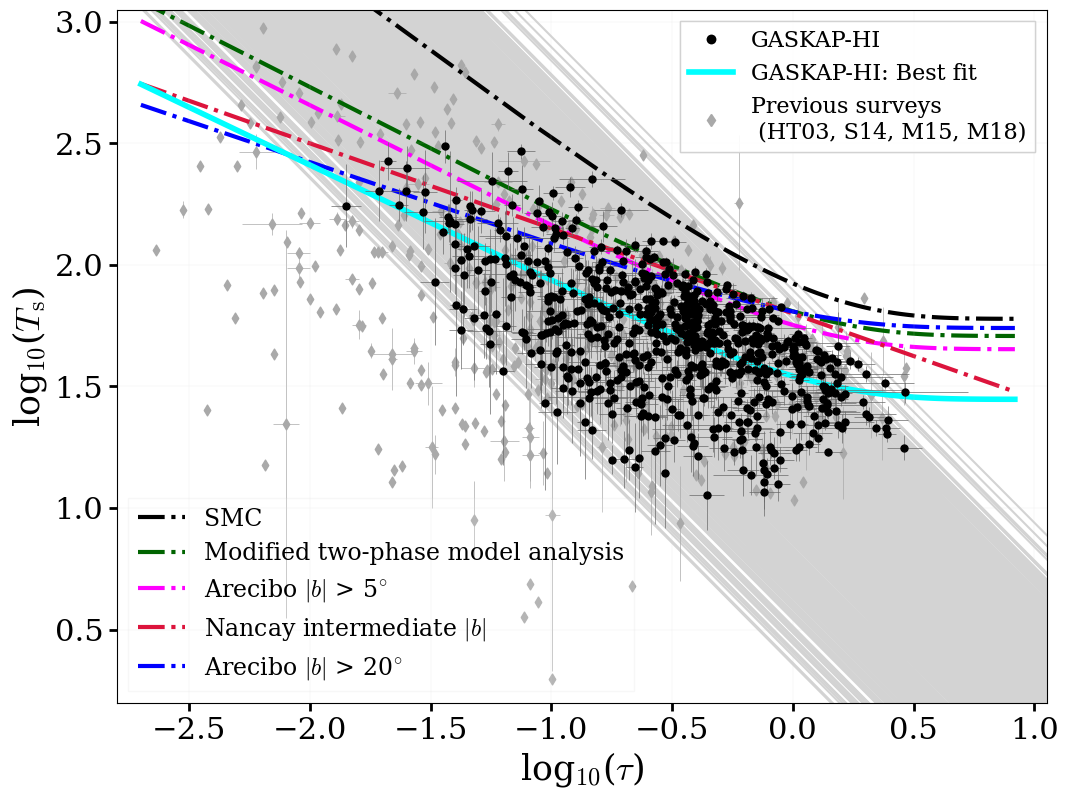

In [137]:
from scipy import stats

x_tau = np.linspace(0.014, 3.3, 100)
x_tau = np.linspace(0.002, 8.3, 100)
payne_ts = 55*(1.-np.exp(-x_tau))**(-0.34) # |b| > 30 deg, using Arecibo
dickey_ts = 45*(1.-np.exp(-x_tau))**(-0.5) # Arecibo, |b| > 5
liszt_ts = 51*(1.-np.exp(-x_tau))**(-0.51) # modified two-phase model in which Tsp is correlated with the absorbing-gas column density and varies as described in § IV of the text. 

# Dickey et al. 2000, https://iopscience.iop.org/article/10.1086/308953/pdf
smc_ts = 60*(1.-np.exp(-x_tau))**(-0.73) # SMC, Ts(v) = TB(v)/(1 - e^-tau(v)) at Gaussian center V0
simple_ts = 86.*x_tau**(-0.56) # Fitting a simple power law to the open circles in Figure 18 gives The latter Ts = 86tau^-0.56.


# Lazareff, B., 1975, https://ui.adsabs.harvard.edu/abs/1975A%26A....42...25L/abstract
lazaref_logts = 1.8 - 0.35*np.log10(x_tau) # Nancay radio telescope, Muedon, 33 absorption measurements at intermediate latitudes




# Figure
fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)

ecolor = 'dimgray'
ccolor = 'darkgrey'

# HT03
ynew = np.log10(mil_cpn_ts)
xnew = np.log10(mil_cpn_tau)

y_err = mil_cpn_sigts/mil_cpn_ts/np.log(10)
x_err = mil_cpn_sigtau/mil_cpn_tau/np.log(10)


cm = mpl.cm.get_cmap('cool')
ax.errorbar(xnew, ynew,
             xerr=x_err, yerr=y_err, zorder=1, 
             ls='None', markersize=2,
             markeredgecolor=ccolor, markeredgewidth=1,
             ecolor=ccolor, elinewidth=0.5,
             label='')

sct = ax.scatter(xnew, ynew, zorder=1, s=30, c = ccolor, marker='d', label='')


# S14
ynew = np.log10(per_cpn_ts)
xnew = np.log10(per_cpn_tau)

y_err = per_cpn_sigts/per_cpn_ts/np.log(10)
x_err = per_cpn_sigtau/per_cpn_tau/np.log(10)

sct = ax.scatter(xnew, ynew, zorder=1, s=30, c = ccolor, marker='d', label='')

ploti, = plt.plot([], [], marker='d', color=ccolor, lw=3)
ploti.set_visible(True)





# SPONGE
ynew = np.log10(spo_cpn_ts)
xnew = np.log10(spo_cpn_tau)

y_err = spo_cpn_sigts/spo_cpn_ts/np.log(10)
x_err = spo_cpn_sigtau/spo_cpn_tau/np.log(10)


cm = mpl.cm.get_cmap('cool')

sct = ax.scatter(xnew, ynew, zorder=1, s=30, c = ccolor, marker='d', label='')

ploti, = plt.plot([], [], marker='d', color=ccolor, lw=3)
ploti.set_visible(True)


lw = 3
lines0 = []
l1, = ax.plot(np.log10(x_tau), np.log10(smc_ts), ls='-.', c='k', zorder=1, lw=lw, label='SMC') # (Dickey et al. 2000)
lines0.append(l1)
l1, = ax.plot(np.log10(x_tau), np.log10(liszt_ts), ls='-.', c='darkgreen', zorder=1, lw=lw, label='Modified two-phase model analysis') # (Liszt 1983)
lines0.append(l1)

l1, = ax.plot(np.log10(x_tau), np.log10(dickey_ts), ls='-.', c='magenta', zorder=1, lw=lw, label=r'Arecibo $|b|$ > 5$^{\circ}$') # (Dickey et al. 1978)
lines0.append(l1)
# ax.plot(np.log10(x_tau), np.log10(simple_ts), label='Simple Ts')
l1, = ax.plot(np.log10(x_tau), lazaref_logts, ls='-.', c='crimson', lw=lw, zorder=1, label='Nancay intermediate $|b|$') #(Lazareff 1975)
lines0.append(l1)
l1, = ax.plot(np.log10(x_tau), np.log10(payne_ts), ls='-.', c='blue', lw=lw, zorder=1, label=r'Arecibo $|b|$ > 20$^{\circ}$') # (Payne et al. 1983)
lines0.append(l1)






# GASKAP
ecolor = 'dimgrey'
gcolor = 'k'
ynew = np.log10(tscnm)
xnew = np.log10(fg_taucnm)

y_err = sigtscnm/tscnm/np.log(10)
x_err = fg_sigtaucnm/fg_taucnm/np.log(10)



# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(xnew, ynew)
print('slope:', slope)
print('intercept:', intercept)


# Perform curve fitting
popt, pcov = curve_fit(model_function, fg_taucnm, tscnm, p0=[30., -0.5])

a_fit, b_fit = popt
a_uncertainty, b_uncertainty = np.sqrt(np.diag(pcov))
print(f"Fitted parameters: a = {a_fit:.4f} ± {a_uncertainty:.4f}, b = {b_fit:.4f} ± {b_uncertainty:.4f}")


# Generate x values for the fitted curve
x_fit = np.linspace(min(fg_taucnm), max(tscnm), 100)
y_fit = model_function(x_fit, *popt)





cm = mpl.cm.get_cmap('cool')
ax.errorbar(xnew, ynew,
             xerr=x_err, yerr=y_err, zorder=2, 
             ls='None', markersize=2,
             markeredgecolor=ecolor, markeredgewidth=1,
             ecolor=ecolor, elinewidth=0.5,
             label='')

sct = ax.scatter(xnew, ynew, zorder=2, s=25, c = gcolor, label='')

lines1 = []
ploti, = plt.plot([], [], marker='o', ls='', color=gcolor, lw=3, label=f'GASKAP-HI')
ploti.set_visible(True)
lines1.append(ploti)

fitted_ts = 28*(1.-np.exp(-x_tau))**(-0.48) # SMC
ploti, = ax.plot(np.log10(x_tau), np.log10(fitted_ts), ls='-', c='cyan', lw=lw+1, zorder=1, label=r'GASKAP-HI: Best fit')
lines1.append(ploti)

ploti, = plt.plot([], [], marker='d', ls='', color=ccolor, lw=3, label=f'Previous surveys \n (HT03, S14, M15, M18)')
ploti.set_visible(True)
lines1.append(ploti)



xtmp = np.linspace(-3., 2.)
fitted_ts = 28*(1.-np.exp(-x_tau))**(-0.48) # SMC


# NHI_CNM_CPN from GASKAP
tau_test_max = 0.
src_test = ''
for (srci,sigma_v,nhicnmi) in zip(src_list_cpn,widcnm,nhicnm_cpn):
    nhicnmi = nhicnmi*1.e20
    sigma_v = sigma_v / 2.35
    tspin_arr = np.arange(1., 1200., 10.)
    tau_arr = tspin_arr*0.
    for k,tsi in enumerate(tspin_arr):
        tau_peak = nhicnmi/tsi/constC/sigma_v/np.sqrt(2.*np.pi)
        tau_arr[k] = tau_peak

    ax.plot(np.log10(tau_arr), np.log10(tspin_arr), color='lightgray', ls='-', zorder=0)

    if tau_arr[-1] > tau_test_max:
        tau_test_max = tau_arr[-1]
        src_test = srci
# End - for
print(tau_test_max)
print(src_test)


# Add axes labels
ax.set_xlabel(r'log$_{10}$($\tau$)', fontsize=25)
ax.set_ylabel(r'log$_{10}$($T_\mathrm{s}$)', fontsize=25)


ax.tick_params(axis='x', labelsize=22, pad=4)
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.set_xlim(-2.8, 1.05)
ax.set_ylim(0.2, 3.05)

first_legend = ax.legend(handles=lines0, loc='lower left', fancybox=False, frameon=True, framealpha=0.15, labelcolor='k', fontsize=17)
ax.add_artist(first_legend)

second_legend = ax.legend(handles=lines1, loc='upper right', fancybox=False, frameon=True, framealpha=0.75, labelcolor='k', fontsize=16)
ax.add_artist(second_legend)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()